In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
# from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
# tf.set_random_seed(seed)
tf.random.set_seed(seed)

# importing data directly from the kaggle
by installing kaggle api and we can import data from there for that first we have to create in our kaggle account, then we get a joson file and we have to upload on google colab by using google.colab module

In [11]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-29 09:48:26           3374        220  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           3336        100  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease             Personal Key Indicators of Heart Disease             3MB  2022-02-16 10:18:03           5799        122  1.0              
datasets/vivek4

Downloading Data directly from kaggle.

In [14]:
#  kaggle datasets download 
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:19<00:00, 183MB/s]
100% 2.29G/2.29G [00:19<00:00, 124MB/s]


Unzipping data file

In [15]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [16]:
import os
print(os.getcwd())
input_path = '/content/chest_xray/chest_xray'

print('worikng directoary before:', os.getcwd())
os.chdir(input_path)
print('worikng directoary after:', os.getcwd())
os.listdir()

/content
worikng directoary before: /content
worikng directoary after: /content/chest_xray/chest_xray


['train', 'val', 'test', '.DS_Store']

In [17]:
# giving the directoary name of files
for i, _set in enumerate(['train', 'val', 'test']):
  print(input_path+'/'+_set)

/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/test


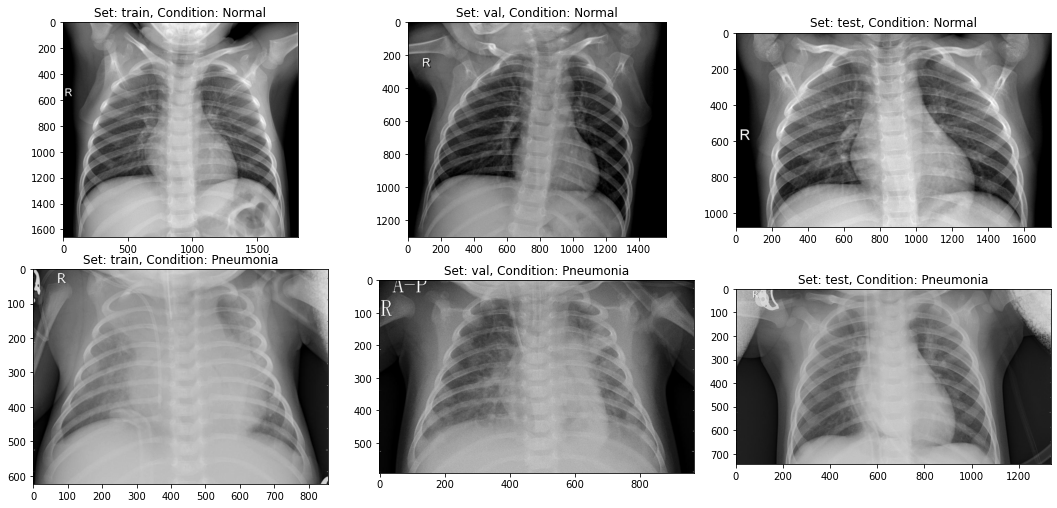

In [18]:
input_path = '/content/chest_xray/chest_xray'

# making for understanding about the dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    # set_path = input_path+_set
    set_path = input_path+'/'+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [19]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + '/'+_set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + '/'+_set + '/PNEUMONIA'))

    # n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [20]:
input_path = '/content/chest_xray/chest_xray/'

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [21]:
#In general a value between 32 and 128 should work well. 
#Usually you should increase/decrease the batch size according to computational resources and model’s performances.
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 64
# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# training image data with Convulational Neural Network,which five layers
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [23]:
# Training the model with train datset
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
81/81 [==============================] - 291s 4s/step - loss: 0.3869 - accuracy: 0.8191 - val_loss: 0.7811 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - 277s 3s/step - loss: 0.2661 - accuracy: 0.8861 - val_loss: 0.7230 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9095
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
81/81 [==============================] - 276s 3s/step - loss: 0.2323 - accuracy: 0.9095 - val_loss: 0.7367 - val_accuracy: 0.6285 - lr: 0.0010
Epoch 4/10
81/81 [==============================] - 277s 3s/step - loss: 0.2038 - accuracy: 0.9251 - val_loss: 1.0329 - val_accuracy: 0.6233 - lr: 3.0000e-04
Epoch 5/10
81/81 [==============================] - 278s 3s/step - loss: 0.1818 - accuracy: 0.9288 - val_loss: 1.3868 - val_accuracy: 0.6163 - lr: 3.0000e-04
Epoch 6/10
81/81 [==============================] - 279s 3s/ste

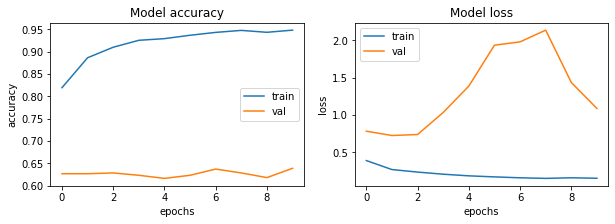

In [24]:
# model accuracy and loss on traing and valdation data
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:

# here we used confusion metrics for calculating the quality of the model
# we also calculate accuracy score
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

# accuracy score
acc = accuracy_score(test_labels, np.round(preds))*100

# confusion matrix
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('--------------------CONFUSION MATRIX ------------------')
print(cm)

print('\n-------------------TEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\n--------------------TRAIN METRIC ----------------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

--------------------CONFUSION MATRIX ------------------
[[  3 231]
 [  0 390]]

-------------------TEST METRICS ----------------------
Accuracy: 62.980769230769226%
Precision: 62.80193236714976%
Recall: 100.0%
F1-score: 77.1513353115727

--------------------TRAIN METRIC ----------------------
Train accuracy: 94.78


# **Saving the model**

In [27]:
import os.path
if os.path.isfile('/content/pneumonia_model.h5') is False:
  model.save('/content/pneumonia_model.h5')

# **This .h5 file saved the things**
1.   The architechtture of the model allow to re-create the model.
2.   The weights of the model.

1.   The traing configuration(loss,optimizer).
2.   The state of the optimizer, allowing to resume training exactly where you left off.





In [29]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
wieghts  = '/content/pneumonia_model.h5'
new_model = load_model( wieghts)

In [31]:
# now summmary of the model
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344  

In [32]:
# now summary of orginal trained model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344  

We can see both are same model and new_model is weights of the dataset.